## Requirements

### Imports

In [1]:
import os
import torch
from pathlib import Path

In [2]:
import training

In [3]:
torch.manual_seed(42)

### Paths

In [4]:
SRC_DIR = Path.cwd()
ROOT_DIR = SRC_DIR.parent

DATA_DIR = os.path.join(ROOT_DIR, 'dataset')
PREPROCESSED_DIR = os.path.join(DATA_DIR, 'preprocessed')
CSV_PATH = os.path.join(DATA_DIR, 'csv_mappings', 'train.csv')

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
BASELINE_DIR = os.path.join(MODEL_DIR, 'baselines')
RESULT_DIR = os.path.join(BASELINE_DIR, 'results')

### Load Data

In [5]:
BATCH_SIZE = 32

In [6]:
CLASS_NAMES = {
    0: "amanita",
    1: "boletus",
    2: "chantelle",
    3: "deterrimus",
    4: "rufus",
    5: "torminosus",
    6: "aurantiacum",
    7: "procera",
    8: "involutus",
    9: "russula"
}

In [7]:
train_loader, val_loader, test_loader = training.get_data_loaders(PREPROCESSED_DIR, CSV_PATH, BATCH_SIZE)

### Training

##### Training config

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_CLASSES = 10 
EPOCHS = 20
PATIENCE = 3
LEARNING_RATE = 0.0001

SCHEDULER = 'StepLR' # StepLR # OneCycleLR # None

##### Set model to train

In [12]:
FINETUNE = False    # True False

model_type = 'vgg16'  
# alexnet # resnet # vgg16 # densenet # efficientnet
# custom_alexnet custom_resnet

In [13]:
model, optimizer, criterion, scheduler, save_path, writer = training.set_model_for_training(
    model_type, train_loader, EPOCHS, LEARNING_RATE, NUM_CLASSES, DEVICE, SCHEDULER, FINETUNE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

##### Train model

In [ ]:
model = training.train_and_validate(
                            model, 
                            train_loader, 
                            val_loader, 
                            criterion, 
                            optimizer, 
                            epochs=EPOCHS, 
                            device=DEVICE, 
                            writer=writer, 
                            scheduler=scheduler, 
                            patience=PATIENCE, 
                            save_path=os.path.join(save_path, f'{model_type}.pth')
                            )
writer.close()

### Evaluate

In [39]:
avg_test_loss, test_accuracy, all_labels, all_predictions = training.evaluate_model(
    model, test_loader, criterion, DEVICE)

[Test]:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\src\training.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exp

Test Loss = 2.3467
Test Accuracy = 11.55%


##### Per class accuracy

Class accuracies:
(0 ) amanita             : 0.3243
(1 ) boletus             : 0.0000
(2 ) chantelle           : 0.0698
(3 ) deterrimus          : 0.0000
(4 ) rufus               : 0.0000
(5 ) torminosus          : 0.0000
(6 ) aurantiacum         : 0.0000
(7 ) procera             : 0.0000
(8 ) involutus           : 0.0370
(9 ) russula             : 0.9259
Per-class accuracy plot saved to c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\models\baselines\vgg16\results\plot_per_class_accuracy.png


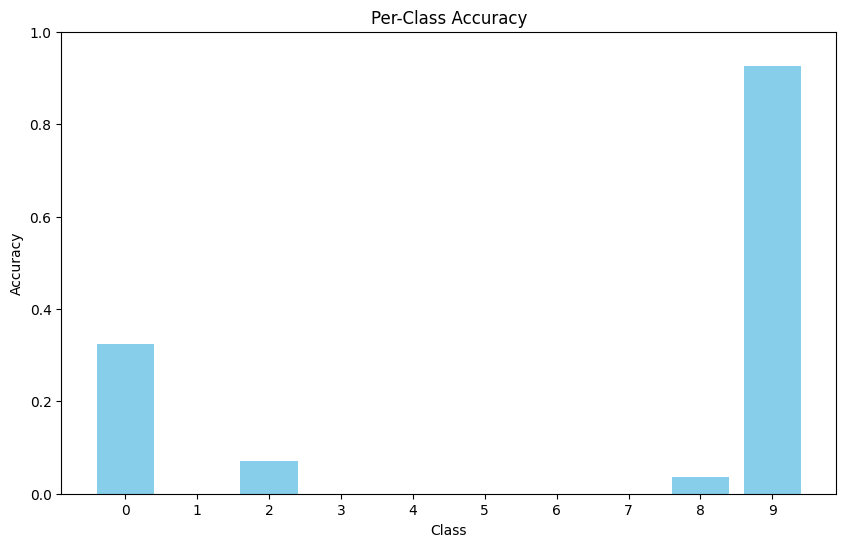

In [40]:
per_class_acc = training.per_class_accuracy(all_labels, all_predictions, NUM_CLASSES, CLASS_NAMES, save_path)

##### Classification report

In [41]:
report_df = training.display_classification_report(all_labels, all_predictions)

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

,precision,recall,f1-score,support
0,0.363636,0.324324,0.342857,37.000000
1,0.000000,0.000000,0.000000,47.000000
2,0.125000,0.069767,0.089552,43.000000
3,0.000000,0.000000,0.000000,34.000000
4,0.000000,0.000000,0.000000,35.000000
5,0.000000,0.000000,0.000000,40.000000
6,0.000000,0.000000,0.000000,30.000000
7,0.000000,0.000000,0.000000,35.000000
8,0.166667,0.037037,0.060606,27.000000
9,0.088968,0.925926,0.162338,27.000000


##### Confusion matrix

Confusion matrix saved to c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\models\baselines\vgg16\results\plot_confusion_matrix.png


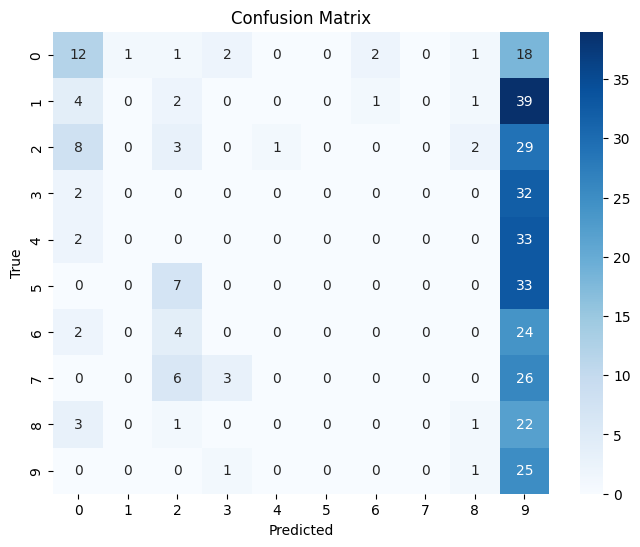

In [42]:
training.plot_confusion_matrix(all_labels, all_predictions, NUM_CLASSES, save_path)

##### Save evaluation

In [43]:
training.save_evaluation_results(
    save_path=save_path,
    avg_test_loss=avg_test_loss,
    test_accuracy=test_accuracy,
    all_labels=all_labels, 
    all_predictions=all_predictions,
    per_class_acc=per_class_acc,
    num_classes=NUM_CLASSES
)

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no